# Test MODFLOW New Style

## Packages

In [1]:
from pathlib import Path

import flopy
import pastas as ps

from pastas_plugins import modflow as ppmf

bindir = Path("bin")
if not (bindir / "mf6").exists():
    bindir.mkdir(parents=True, exist_ok=True)
    flopy.utils.get_modflow(bindir, repo="modflow6")

## Load Data

In [2]:
ds = ps.load_dataset("collenteur_2019")
head = ds["head"].squeeze().dropna()
prec = ds["rain"].squeeze().dropna().resample("D").asfreq().fillna(0.0)
evap = ds["evap"].squeeze().dropna()

## Test

### Pastas Model

In [3]:
ml = ps.Model(head, name="pastas")
rm = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="rch")
ml.add_stressmodel(rm)
ml.solve()

Fit report pastas                 Fit Statistics
nfev    11                     EVP         87.10
nobs    5737                   R2           0.87
noise   False                  RMSE         0.42
tmin    2003-01-01 00:00:00    AICc     -9870.13
tmax    2018-12-25 00:00:00    BIC      -9843.52
freq    D                      Obj        512.71
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
rch_A       331.311202  29.925748  True
rch_a        98.430976  10.000000  True
rch_f        -0.854493  -1.000000  True
constant_d  -14.150486 -11.740288  True


<Axes: xlabel='Date', ylabel='Head'>

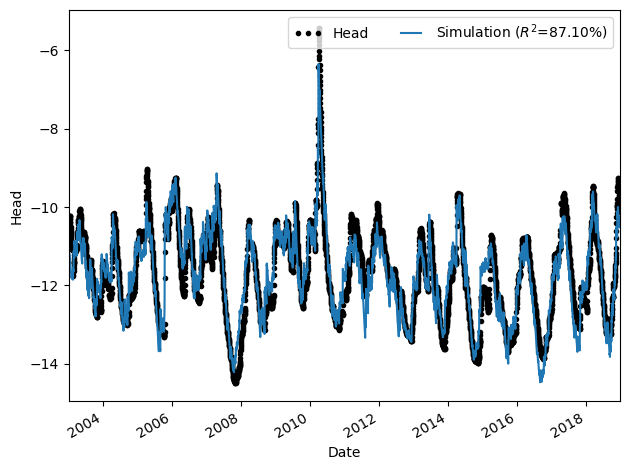

In [4]:
ml.plot()

### Pastas Model with MODFLOW plugin

In [5]:
ml = ps.Model(head, name="mftest")
mfml = ppmf.ModflowModel(
    ml,
    exe_name=bindir / "mf6",
    sim_ws=Path("mftest"),
    silent=True,
)
rch = ppmf.ModflowRch(prec, evap)
ghb = ppmf.ModflowGhb()
mfml.add_modflow_package([rch, ghb])
ml.add_stressmodel(mfml)
# ml.simulate(p=ml.parameters.initial.values)
ml.solve()

Stressmodel mfsm has no rfunc


Fit report mftest                 Fit Statistics
nfev    85                     EVP         86.43
nobs    5737                   R2           0.86
noise   False                  RMSE         0.43
tmin    2003-01-01 00:00:00    AICc     -9568.77
tmax    2018-12-25 00:00:00    BIC      -9542.16
freq    D                      Obj        540.36
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
          optimal    initial   vary
mfsm_d -14.182809 -11.740288   True
mfsm_H   1.000000   1.000000  False
mfsm_S   0.306760   0.050000   True
mfsm_f  -0.827921  -1.000000   True
mfsm_C   0.003038   0.001000   True

Warnings! (1)
Response tmax for 'mfsm' > than calibration period.


<Axes: xlabel='Date', ylabel='Head'>

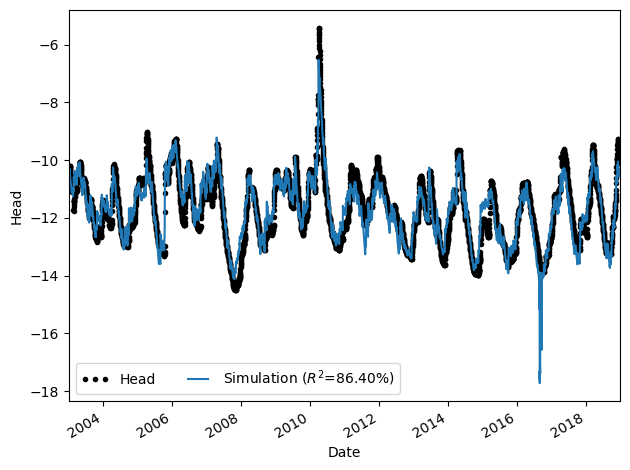

In [6]:
ml.plot()